# Simulating Network Deliberation 

In [1]:
# Configure plotting in Jupyter
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({
    'figure.figsize': (7.5, 7.5),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})
# Seed random number generator
import random
from numpy import random as nprand

In [2]:
# Import NetworkX
import networkx as nx
import numpy as np

### Assign nodes to groups 

In [3]:
from learning import *

In [4]:
from topologies import *

## Generates topologies

In [5]:
def generate_long_path(N, M, stage):
    '''Generates a long path network
    #Parameters:
    N: number of participants 
    M: number of participants per group
    stage: stage in the ;earning process
    
    #Returns 
    a long path network
    '''

    groups = get_long_path_stage_groups(N, M, stage)
    #print("all the groups", groups)
    G = nx.Graph()
    for group in groups:
        #print("group in groups", group) #nodes to form clique network
        g = nx.complete_graph(group) #clique network
        #print("clique network", g.nodes())
        #nx.draw(g)
        G = nx.union(G,g)
    #print("All the edges in graph G are", G.nodes())
    #nx.draw(G)
    return G

In [6]:
def generate_random_path(N, M, stage):
    """ Generates a radom network
    #Parameters
    N: number of participants 
    M: number of participants per group
    stage: stage in the ;earning process
    
    #Returns 
    a long path network
    
    """
    groups = get_random_stage_groups(N, M, stage)
    #print("all the groups", groups)
    G = nx.Graph()
    for group in groups:
        #print("group in groups", group) #nodes to form clique network
        g = nx.complete_graph(group) #clique network
        #print("clique network", g.nodes())
        #nx.draw(g)
        #adds cliques to a network 
        G = nx.union(G,g)
        #print("All the edges in graph G are", G.nodes())
        #nx.draw(G
    return G

In [7]:
def generate_sw(N, M, stage):
    '''Generates a small world network
    #Parameters
    N: number of participants 
    M: number of participants per group
    stage: stage in the ;earning process
    
    #Returns 
    a SW network
    '''
    stage = 0
    M = 0
    
    G = nx.watts_strogatz_graph(N, 4, 0.1)
    
    return G

In [8]:
def generate_preferential(N, M, stage):
    '''Generates a small world network
    #Parameters
    N: number of participants 
    M: number of participants per group
    stage: stage in the ;earning process
    
    #Returns 
    a preferential attachment network
    '''
    stage = 0
    M = 0
    
    G = nx.barabasi_albert_graph(N, 2)
    
    return G

## run_trial

In [94]:
def run_trial(Graph, learning_strategy, true_value, runs = 10, stage_graphs=True):
    """
    Plots the fraction of correct nodes in all stages of a simulation
    
    #Parameters:
    Graph: topology
    learning strategy: learning strategy to simulate in topology
    intial beliefs are generated inside the topology: prarms (G, true_value, p_error)
    true_value: the ground truth 
    runs: the number of runs 
    stage_graphs: checks if the graph needs to be change in subsequent stages
    plot: plotting function used to plot beliefs  (fixed for now)
    stages: for now is fixed, eventually will change. (fixed for now) 
    
    return
    a dictrionary of lists. the keys are the number of the run, and the val is the fract of nodes with correct beliefs
    """

    N = 100 #num of participants(nodes)
    M = 5 #group size
    stages = 5  #stages
    steps = 5 #number of steps in each learning stratey


    #keep values of each run: key: # run val: plot_belief_bits_correct
    runs_list_fract_corrrect = dict((run, list()) for run in range(runs)) #for each bit creates an empty list. 
    
    for run in range(runs):
        beliefs_stages = []
        #print("To keep beliefs after stages", beliefs_stages)
    
        for stage in range(stages):

            if stage == 0: 
                G = Graph(N, M, stage)
                ini_beliefs = initial_beliefs_noisy(G, true_value, p_error= .40)
                beliefs_stages = [ini_beliefs]
                #print("Stage #", stage)
                #print("The initial beliefs at stage", stage, "are", ini_beliefs)
                beliefs_list =  learn(G, ini_beliefs, learning_step_best_neighbor, true_value, steps)
                beliefs_stages += beliefs_list
                #print("Beliefs at stage", stage, "after learn() are", beliefs_stages)

            else:
                if stage_graphs:
                    G = Graph(N, M, stage)
                sub_ini_beliefs = beliefs_stages[-1]
                #print("Stage #", stage)
                #print("The initial beliefs at stage", stage, "are", sub_ini_beliefs)
                beliefs_list = learn(G, sub_ini_beliefs, learning_step_best_neighbor, true_value, steps)
                beliefs_stages += beliefs_list
                #print("Beliefs at", stage, "after learn() are", beliefs_stages)
        runs_list_fract_corrrect[run] += plot_beliefs_correct(beliefs_stages, true_value)
    return runs_list_fract_corrrect

In [133]:
def st_dp_all_runs(Graph, learning_strategy, true_value):
    '''Takes the values of all runs and finds the mean
    #Parameters 
    Graph: given topology/network 
    learning_strategy: learning strategy to simulate in topology
    true_value: the ground truth 
    
    #Returns a plot of mean value of all the runs
    '''
    runs_list_fract_corrrect = run_trial(Graph, learning_strategy, true_value)
    #print(runs_list_fract_corrrect)

    #runs && num_stpes are use to iterate through each step 
    runs = list(runs_list_fract_corrrect.keys())
    #print("runs", runs)
    #total num of steps each run
    num_steps = len(runs_list_fract_corrrect[runs[0]])
    #print(num_steps)

    #keep values of all the values in each index: key: index; val: fraction of nodes
    fract_corrrect_step = dict((step, list()) for step in range(num_steps)) #for each bit creates an empty list. 
    #print(fract_corrrect_step)



    for run in runs_list_fract_corrrect:
        #Prints the list of values at each run
        #print("Run and list of values at each step", runs_list_fract_corrrect[run])
        #val_step = runs_list_fract_corrrect[run][step]
        #print("Val at step new variable", val_step)
        for step in range(num_steps):
            #gets the fraction of nodes at step [step]
            #print("Value at step", runs_list_fract_corrrect[run][step])
            #appends the raction of nodes at step [step] to fract_corrrect_step[step] dictrionary
            fract_corrrect_step[step].append(runs_list_fract_corrrect[run][step])
            #print(fract_corrrect_step[step])

    #print("Dict: Holds 26 steps as keys, and list of 9 values (corresponds to 9 runs)", fract_corrrect_step)

    #frac_nodes_one = sum(node_bit_value) / len(node_bit_value)

    y = []
    y_error = []
    for step in fract_corrrect_step:
        #should give 26 key:value(list) pairs. Each list has 9 values (runs)
        #print("Gives the list of values at index", fract_corrrect_step[step])

        #sum_steps = sum(fract_corrrect_step[step])
        #print("Sum of step", sum_steps)

        #mean_each_step = sum_steps / len(runs)
        mean_each_step = np.mean(fract_corrrect_step[step])
        sd_each_step = np.std(fract_corrrect_step[step])
        
        #print("Average step", mean_each_step)

        y.append(mean_each_step)
        y_error.append((1.96*sd_each_step/len(fract_corrrect_step[step])))
        #print(y)
        
    #print("Fraction over all runs", y)
    #print("Error at each step of all runs",y_error)
    x = list(range(0, 26))
    #print("X axis", x)
    
    plt.plot(x, y, 'p-', alpha=0.3, linewidth=2)

    plt.errorbar(x, y, yerr = y_error, fmt='-o', ecolor='g', capthick=2)

    #add spines to plot
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(True)
    #ax.locator_params(nbins=4)
    #eventually need to add x limits
    plt.xlim([0, 26]) 
    #plt.xticks(np.arange(0,steps,1))
    plt.ylim([0, 1.1])
    plt.yticks(np.arange(0,1.1,0.1))
    plt.xlabel("Number of steps")
    plt.ylabel("Fraction of nodes")
    plt.legend()
        


In [134]:
#x = list(range(0, 27))
#print(x)

In [135]:
networks = {
    'Long Path': (generate_long_path, True),
    'Random Path': (generate_random_path, True),
    'Preferential Attachment': (generate_preferential, False),
    'Small World': (generate_sw, False)}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


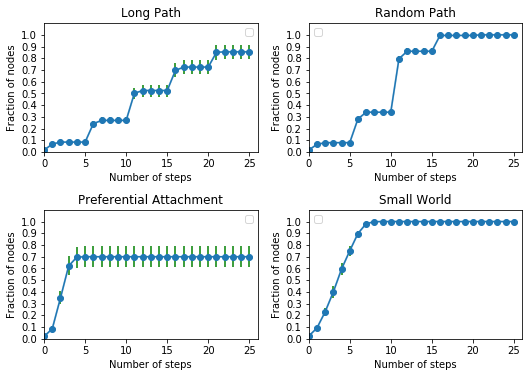

In [137]:
for i, (title, (Graph, sg)) in enumerate(networks.items()):
    plt.subplot(3, 2, i + 1)
    plt.title(title)
    st_dp_all_runs(Graph, rand_neighbor_list, true_value = [1,1,1,1,1,1,1,1])
plt.tight_layout()

# Old plotting

# old plotting code 

# old code 

In [ ]:
#gets number of steps in each run
#num_steps = range(len((runs_list_fract_corrrect[run])
#print("Number of steps", num_steps)


#gets the list of vals at each run
#for run_fraction in runs_list_fract_corrrect:
 #   print("The correct number of nodes at", run, "are :", runs_list_fract_corrrect[run])
  #  for step in runs_list_fract_corrrect[run]:
   #     print(step)
        #fract_corrrect_step[step].append(step)
    
    #temp function to append the vals at index(step) of all runs
    #temp_fracts = []
    
    #step is the index of the list runs_list_fract_corrrect[run]
    #for step in run_fraction:
        #print("Value at index", step)
        #temp_fracts.append(runs_list_fract_corrrect[run]) #creates a temp list to hold all the fractions at index step of all runs
    #print("val at index:", temp_fracts)
        #fract_corrrect_step[step] = temp_fracts
#print(fract_corrrect_step)

# current_beliefs = beliefs_list #a list of dict. each key:value pair is a node, and a LIST of beliefs.

#determine number of bits 
#nodes = list(current_beliefs.keys()) 
#print(nodes) #runs
#num_bit = list(current_beliefs[nodes[0]])
#print(num_bit)

#y = dict((bit, list()) for bit in range(num_bit))

#takes the list of beliefs in each iteration. Then for each bit, takes the fraction that 
#have a 1 and adds them to y (the plotting varaible)
#for steps_beliefs in current_beliefs:
#    for bit in range(num_bit):
#        bit_avg = get_belief_bit_fraction(steps_beliefs, bit) 
#        y[bit].append(bit_avg) 

#plot the fract of nodes in bit that have a one
#for bit in y:
#    plt.plot(y[bit], '-', alpha=0.4, linewidth=2, label  = str(bit))